In [112]:
import os
import sys
import numpy as np
import json
import pathlib
import h5py

from ridge_utils.stimulus_utils import load_textgrids, load_simulated_trfiles
from ridge_utils.dsutils import make_semantic_model, make_word_ds, make_phoneme_ds


def get_story_wordseqs(stories):
    grids = load_textgrids(stories)
    with open("/home/jajoosam/data/ds003020/derivative/respdict.json", "r") as f: # change this path!
        respdict = json.load(f)
    trfiles = load_simulated_trfiles(respdict)
    wordseqs = make_word_ds(grids, trfiles)
    return wordseqs

def get_response(stories, subject="UTS01"):
    """Get the subject"s fMRI response for stories."""
    main_path = pathlib.Path(os.path.join(os.getcwd())).parent.parent.resolve()
    subject_dir = "/home/jajoosam/data/ds003020/derivative/preprocessed_data/%s" % subject # change this path!
    base = os.path.join(main_path, subject_dir)
    resp = []
    for story in stories:
        resp_path = os.path.join(base, "%s.hf5" % story)
        hf = h5py.File(resp_path, "r")
        resp.extend(hf["data"][:])
        hf.close()
    return np.array(resp)

In [113]:
stories = ["naked"]

In [114]:
word_sequences = get_story_wordseqs(stories)
brain_response = get_response(stories)

In [115]:
brain_response.shape

(422, 81126)

In [116]:
story = word_sequences["naked"]

In [117]:
chunks = np.array([np.array(word_sequences[story].chunks()[10:-5]) for story in stories])

/tmp/ipykernel_4013246/3372831984.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  chunks = np.array([np.array(word_sequences[story].chunks()[10:-5]) for story in stories])


In [118]:
chunks = chunks[0]

In [119]:
" ".join(list(chunks[0])[0])

's o'

In [120]:
from sentence_transformers import SentenceTransformer
sentences = [" ".join(list(chunk)) for chunk in chunks]

model = SentenceTransformer('sentence-transformers/msmarco-distilbert-base-v2')
bert_embeddings = model.encode(sentences)
print(bert_embeddings.shape)

(422, 768)


In [121]:
b = []
import math

for fmri in brain_response:
    app = []
    for el in fmri:
        if(not math.isnan(el)):
            app.append(el)
    b.append(app)

In [122]:
brain_response = np.array(b)

In [123]:
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

k = 5 # number of neighbours found
n = 50 # number of latent dimensions formed with PCA

In [124]:
def get_accuracy(brain_response, bert_embeddings, k, n):
    pca = PCA(n_components=n)
    brainPrincipalComponents = pca.fit_transform(brain_response)
    
    brain_nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(brainPrincipalComponents)
    bert_nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(bert_embeddings)

    _, brain_indices = brain_nbrs.kneighbors(brainPrincipalComponents)
    _, bert_indices = bert_nbrs.kneighbors(bert_embeddings)
    
    accuracy = []

    for i in range(len(bert_indices)):
        brain_knn = brain_indices[i]
        bert_knn = bert_indices[i]
        correct = 0
        for nbr in brain_knn:
            if nbr in bert_knn:
                correct+=1
        accuracy.append(correct/k) 
    accuracy = np.array(accuracy)
    
    return accuracy.mean()

In [125]:
get_accuracy(brain_response, bert_embeddings, k, n)

0.22037914691943128

In [150]:
import matplotlib.pyplot as plt

k = 50 # default k
n = 5 # default n

k_list = np.arange(5, 300, 5)
n_list = np.arange(10, 400, 50)

In [151]:
accuracy_with_k = []
accuracy_with_n = []

In [152]:
for temp_k in k_list:
    accuracy = get_accuracy(brain_response, bert_embeddings, temp_k, n)
    accuracy_with_k.append(accuracy)

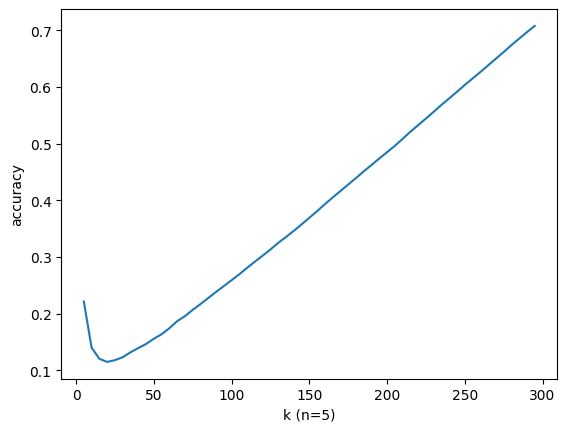

In [153]:
plt.plot(k_list, accuracy_with_k)
plt.ylabel("accuracy")
plt.xlabel(f"k (n={n})")
plt.show()

In [148]:
for temp_n in n_list:
    accuracy = get_accuracy(brain_response, bert_embeddings, k, temp_n)
    accuracy_with_n.append(accuracy)

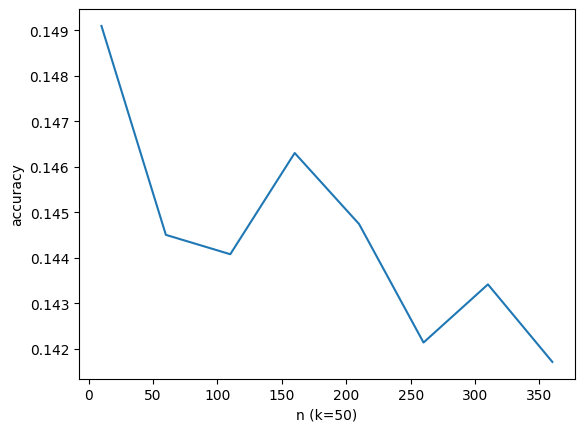

In [149]:
plt.plot(n_list, accuracy_with_n)
plt.ylabel("accuracy")
plt.xlabel(f"n (k={k})")
plt.show()